In [44]:
import scipy.stats as sps
import json
import numpy as np
import joblib
from main import plot,load_data
import matplotlib.pyplot as plt
from mave_calibration.skew_normal import density_utils

In [82]:
dataset_id = "urn_mavedb_00000097-0-1"
config_name = "missense_config"
data_directory = "/mnt/d/mave_calibration/data/"
X,S,sample_names = load_data(dataset_id=dataset_id,
                            config_name=config_name,
                            data_directory=data_directory)
with open(f"/mnt/d/mave_calibration/results/missense_config/{dataset_id}/result.json") as f:
    result = json.load(f)


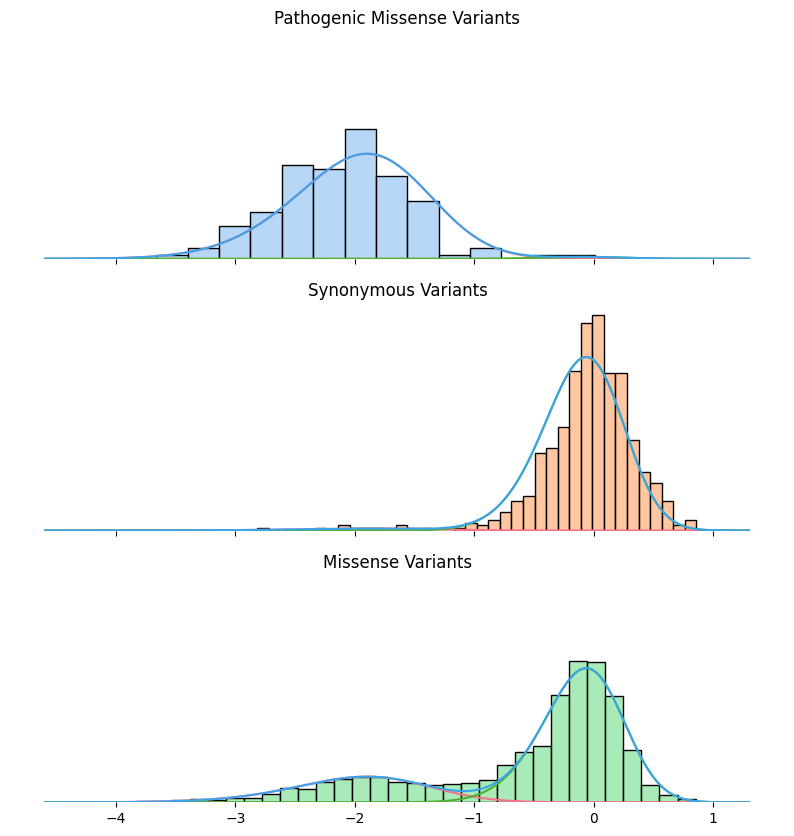

In [83]:
fig,ax = plot(X,S,sample_names,result['weights'],result['component_params'])

In [84]:
def bootstrap(sample):
    return sample[np.random.randint(0,len(sample),size=len(sample))]

In [89]:
_,bin_edges = np.histogram(X[S[:,2]])
P = np.zeros((0,len(bin_edges)-1))
B = np.zeros((0,len(bin_edges)-1))
for _ in range(1000):
    hist_path,_ = np.histogram(bootstrap(X[S[:,0]]),bins=bin_edges)
    hist_path += np.ones_like(hist_path,dtype=int)
    hist_path = hist_path / np.sum(hist_path)

    hist_benign,_ = np.histogram(bootstrap(X[S[:,1]]),bins=bin_edges)
    hist_benign += np.ones_like(hist_benign,dtype=int)
    hist_benign = hist_benign / np.sum(hist_benign)

    P = np.concatenate((P,hist_path[None,:]),axis=0)
    B = np.concatenate((B,hist_benign[None,:]),axis=0)

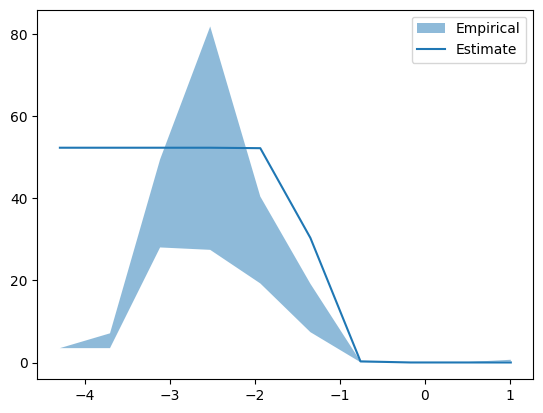

In [90]:
rng = .5 * (bin_edges[:-1] + bin_edges[1:])

LR = P / B
LRM = LR.mean(0)
y1,y2 = np.percentile(LR,[2.5,97.5],axis=0)
plt.fill_between(rng, LRM, y1,y2,alpha=.5,label="Empirical")
f_P = density_utils.joint_densities(rng, result['component_params'], result['weights'][0]).sum(0)
f_B = density_utils.joint_densities(rng, result['component_params'], result['weights'][1]).sum(0)
plt.plot(rng, f_P / f_B, label="Estimate")
plt.legend()